In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import numpy as np

import os
import paths

In [2]:
print(tf.version.VERSION)

2.6.0


In [3]:
data_dir = paths.ABNORMALITY_DATASET + 'healthy'

In [4]:
train_images = tf.keras.utils.image_dataset_from_directory(data_dir, label_mode=None, image_size=(100, 100), batch_size=32)

Found 4104 files belonging to 1 classes.


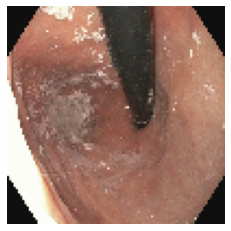

In [5]:
image_batch = next(iter(train_images))
random_index = np.random.choice(image_batch.shape[0])
random_image = image_batch[random_index].numpy().astype("int32")
plt.axis("off")
plt.imshow(random_image)
plt.show()

In [6]:
# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = train_images.map(lambda x: (x - 127.5) / 127.5)

In [7]:
# latent dimension of the random noise
LATENT_DIM = 100 
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 3

In [8]:
def build_generator():
  # create a Keras Sequential model 
  model = Sequential(name='generator')

  # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer  
  model.add(layers.Dense(5 * 5 * 512, input_dim=LATENT_DIM))
  model.add(layers.ReLU())

  # 1D => 3D: reshape the output of the previous layer 
  model.add(layers.Reshape((5, 5, 512)))

  # upsample to 25x25
  model.add(layers.Conv2DTranspose(256, (5, 5), strides=(5, 5),padding="same", kernel_initializer=WEIGHT_INIT))
  model.add((layers.ReLU()))

  # upsample to 50x50
  model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
  model.add((layers.ReLU()))

  # upsample to 100x100
  model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
  model.add((layers.ReLU()))

  # final layer: Conv2D with tanh activation
  model.add(layers.Conv2D(CHANNELS, (4, 4), padding="same", activation="tanh"))

  # return the generator model
  return model

In [9]:
generator = build_generator()

In [10]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12800)             1292800   
_________________________________________________________________
re_lu (ReLU)                 (None, 12800)             0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 25, 25, 256)       3277056   
_________________________________________________________________
re_lu_1 (ReLU)               (None, 25, 25, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 50, 50, 128)       524416    
_________________________________________________________________
re_lu_2 (ReLU)               (None, 50, 50, 128)       0 

In [11]:
def build_discriminator(height, width, depth, alpha=0.2):
  # create a Keras Sequential model
  model = Sequential(name='discriminator')
  input_shape = (height, width, depth)

  # 1. first set of CONV => BN => leaky ReLU layers
  model.add(layers.Conv2D(64, (4, 4), padding="same", strides=(2, 2), input_shape=input_shape))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=alpha))

  # 2. second set of CONV => BN => leacy ReLU layers
  model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=alpha))

  # 3. third set of CONV => BN => leacy ReLU layers
  model.add(layers.Conv2D(128, (5, 5), padding="same", strides=(5, 5)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=alpha))

  # flatten and apply dropout
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.3))

  # sigmoid in the last layer outputting a single value for binary classification
  model.add(layers.Dense(1, activation="sigmoid"))

  # return the discriminator model
  return model

In [12]:
# build the discriminator model
discriminator = build_discriminator(100, 100, 3)

In [13]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 64)        3136      
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)       131200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 128)       

In [14]:
class DCGAN(keras.Model):
  def __init__(self, discriminator, generator, latent_dim):
    super().__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim
    self.d_loss_metric = keras.metrics.Mean(name="d_loss")
    self.g_loss_metric = keras.metrics.Mean(name="g_loss")

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(DCGAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn

  @property
  def metrics(self):
    return [self.d_loss_metric, self.g_loss_metric]

  def train_step(self, real_images):
    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal(shape=(batch_size, self.latent_dim))

    # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
    with tf.GradientTape() as tape:
      # Compute discriminator loss on real images
      pred_real = self.discriminator(real_images, training=True)
      real_labels = tf.ones((batch_size, 1))
      # UPDATED: apply one-sided label smoothing to real labels
      real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels)) 
      d_loss_real = self.loss_fn(real_labels, pred_real)

      # Compute discriminator loss on fake images
      fake_images = self.generator(noise)
      pred_fake = self.discriminator(fake_images, training=True)
      fake_labels = tf.zeros((batch_size, 1))
      # UPDATED: add random noise to fake labels - not needed
      # fake_labels += 0.05 * tf.random.uniform(tf.shape(fake_labels)) 
      d_loss_fake = self.loss_fn(fake_labels, pred_fake)

      # total discriminator loss
      d_loss = (d_loss_real + d_loss_fake)/2
    
    # Compute discriminator gradients
    grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
    # Update discriminator weights
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

    # Step 2. Train the generator (do not update weights of the discriminator)
    misleading_labels = tf.ones((batch_size, 1)) # G wants D to think the fake images are real (label as 1)

    with tf.GradientTape() as tape:
      fake_images = self.generator(noise, training=True)
      pred_fake = self.discriminator(fake_images, training=True)
      g_loss = self.loss_fn(misleading_labels, pred_fake)
 
    # Compute generator gradients
    grads = tape.gradient(g_loss, self.generator.trainable_variables)
    # Update generator wieghts
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)

    return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}


In [15]:
class GANMonitor(keras.callbacks.Callback):
  def __init__(self, num_img=3, latent_dim=100):
    self.num_img = num_img
    self.latent_dim = latent_dim

    # Create random noise seed for visualization during traing
    self.seed = tf.random.normal([16, latent_dim])

  def on_epoch_end(self, epoch, logs=None):
    generated_images = self.model.generator(self.seed)
    generated_images = (generated_images * 127.5) + 127.5
    generated_images.numpy()

    fig = plt.figure(figsize=(4, 4))
    for i in range(self.num_img):
      plt.subplot(4, 4, i+1)
      img = keras.utils.array_to_img(generated_images[i]) 
      plt.imshow(img)
      plt.axis('off')
    plt.show()

  def on_train_end(self, logs=None):
    self.model.generator.save('generator.h5')

In [16]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

In [17]:
D_LR = 0.0001 # UPDATED: discriminator learning rate
G_LR = 0.0003 # UPDATED: generator learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=D_LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=G_LR, beta_1 = 0.5),  
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [19]:
NUM_EPOCHS = 100 # number of epochs
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])

Epoch 1/100
 32/129 [======>.......................] - ETA: 6:04 - d_loss: 1.5213 - g_loss: 0.2943

In [ ]:
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=G_LR, beta_1 = 0.5))
discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=D_LR, beta_1 = 0.5))
generator.save(paths.ABNORMALITY_GANS + 'healthy_generator')
discriminator.save(paths.ABNORMALITY_GANS + 'healthy_discriminator')

In [ ]:
model = tf.keras.models.load_model(paths.ABNORMALITY_GANS + 'healthy_generator')
image_batch = model.predict(np.array((np.random.randint(0, 255, (1, 100)) - 127.5) / 127.5))
random_index = np.random.choice(image_batch.shape[0])
random_image = image_batch[random_index].astype("int32")
plt.axis("off")
plt.imshow(random_image)
plt.show()